In [ ]:
# default_exp data

# Data functionalities

> Generating and importing data

In [ ]:
#export
import gzip
from fastai.vision.all import *

## Loading external data
Most of the functions come from: https://github.com/jhhuang96/ConvLSTM-PyTorch

In [ ]:
ROOT_PATH = Path.cwd().parent
DATA_PATH = Path.cwd().parent/'data'

In [ ]:
#export
def load_mnist(path):
    "Load MNIST dataset for generating training data"
    path = path/'train_images.gz'
    with gzip.open(path, 'rb') as f:
        mnist = np.frombuffer(f.read(), np.uint8, offset=16)
        mnist = mnist.reshape(-1, 28, 28)
    return mnist

In [ ]:
data = load_mnist(DATA_PATH)
test_eq(data.shape, [60000,28,28])

we can show some:

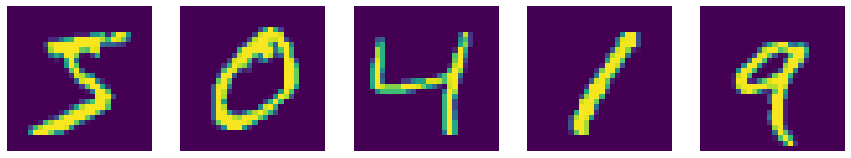

In [ ]:
show_images(data[0:5]);

In [ ]:

# def load_fixed_set(root, is_train):
#     # Load the fixed dataset
#     filename = 'mnist_test_seq.npy'
#     path = os.path.join(root, filename)
#     dataset = np.load(path)
#     dataset = dataset[..., np.newaxis]
#     return dataset


## Generating moving mnist sequences:

In [ ]:
#export
class MovingMNIST:
    def __init__(self, root, n_in, n_out, n_obj, th=None):
        self.dataset = None
        self.mnist = load_mnist(root)
        self.length = int(1e4) if self.dataset is None else self.dataset.shape[1]
        self.num_objects = [n_obj] if not is_listy(n_obj) else n_obj
        self.n_frames_input = n_in
        self.n_frames_output = n_out
        self.n_frames_total = self.n_frames_input + self.n_frames_output
        # For generating data
        self.image_size_ = 64
        self.digit_size_ = 28
        self.step_length_ = 0.1
        self.th = th

    def get_random_trajectory(self, seq_length):
        ''' Generate a random sequence of a MNIST digit '''
        canvas_size = self.image_size_ - self.digit_size_
        x = random.random()
        y = random.random()
        theta = random.random() * 2 * np.pi
        v_y = np.sin(theta)
        v_x = np.cos(theta)

        start_y = np.zeros(seq_length)
        start_x = np.zeros(seq_length)
        for i in range(seq_length):
            # Take a step along velocity.
            y += v_y * self.step_length_
            x += v_x * self.step_length_

            # Bounce off edges.
            if x <= 0:
                x = 0
                v_x = -v_x
            if x >= 1.0:
                x = 1.0
                v_x = -v_x
            if y <= 0:
                y = 0
                v_y = -v_y
            if y >= 1.0:
                y = 1.0
                v_y = -v_y
            start_y[i] = y
            start_x[i] = x

        # Scale to the size of the canvas.
        start_y = (canvas_size * start_y).astype(np.int32)
        start_x = (canvas_size * start_x).astype(np.int32)
        return start_y, start_x

    def generate_moving_mnist(self, num_digits=2):
        "Get random trajectories for the digits and generate a video"
        data = np.zeros((self.n_frames_total, self.image_size_, self.image_size_), dtype=np.float32)
        for n in range(num_digits):
            # Trajectory
            start_y, start_x = self.get_random_trajectory(self.n_frames_total)
            ind = random.randint(0, self.mnist.shape[0] - 1)
            digit_image = self.mnist[ind]
            for i in range(self.n_frames_total):
                top = start_y[i]
                left = start_x[i]
                bottom = top + self.digit_size_
                right = left + self.digit_size_
                # Draw digit
                data[i, top:bottom, left:right] = np.maximum(data[i, top:bottom, left:right], digit_image)

        data = data[..., np.newaxis]
        return data

    def __getitem__(self, idx):
        length = self.n_frames_input + self.n_frames_output
        if self.num_objects[0] != 2:
            # Sample number of objects
            num_digits = random.choice(self.num_objects)
            # Generate data on the fly
            images = self.generate_moving_mnist(num_digits)
        else:
            images = self.dataset[:, idx, ...]
        r = 1
        w = int(64 / r)
        images = images.reshape((length, w, r, w, r)).transpose(0, 2, 4, 1, 3).reshape((length, r * r, w, w))

        input = images[:self.n_frames_input]
        if self.n_frames_output > 0:
            output = images[self.n_frames_input:length]
        else:
            output = []

        frozen = input[-1]
        output = torch.from_numpy(output / 255.0).contiguous().float()
        input = torch.from_numpy(input / 255.0).contiguous().float()
        if self.th is not None:
            return (input>self.th).float(), (output>self.th).long()
        return input, output

    def __len__(self):
        return self.length

This is an random MNIST Dataset:

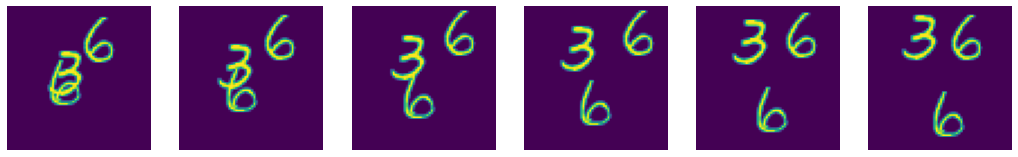

In [ ]:
ds = MovingMNIST(DATA_PATH, n_in=3, n_out=3, n_obj=3)
x,y = ds[0]
test_eq(x.shape, [3,1,64,64])
z = torch.cat([x,y], axis=0)
show_images(z)

If you want a fixed one:

In [ ]:
ds_fixed = [ds[i] for i in range(10)]

Let's refactor all this on a fastai compatible Transform

## As a Transform
Using the mid-level API to build our data pipeline

In [ ]:
#export
class ImageSeq(fastuple):
    @classmethod
    def create(cls, t, cl_type=TensorImageBW):
        return cls(tuple(cl_type(im) for im in t))
    def show(self, ctx=None, **kwargs): 
        return show_image(torch.cat([t for t in self], dim=2), ctx=ctx, **self[0]._show_args, **kwargs)

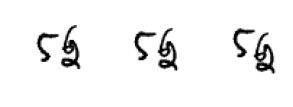

In [ ]:
x,y = ds[0]
ImageSeq.create(x).show(figsize=(5,3));

We will stack 2 `ImageSeq` together on a new class:

In [ ]:
# class DualImageSeq(Tuple):
#     @classmethod
#     def create(cls, t1, t2):
#         return cls(tuple((ImageSeq(t1), ImageSeq(t2))))
#     def show(self, ctx=None, **kwargs): 
#         t1,t2 = self
#         line = t1[0].new_ones(t1[0].shape[0], t1[0].shape[1],2)
#         return show_image(torch.cat([*t1,line,*t2], dim=2), ctx=ctx, **kwargs)

In [ ]:
# dimgs = DualImageSeq.create(x,y)
# dimgs.show(figsize=(10,4));

In [ ]:
#export
class ImageTupleTransform(Transform):
    def __init__(self, ds, cl_type=TensorImageBW):
        self.ds = ds
        self.cl_type = cl_type
        
    def encodes(self, idx):
        x,y = self.ds[idx]
        return ImageSeq.create(x, self.cl_type), ImageSeq.create(y, self.cl_type)

In [ ]:
train_tl = TfmdLists([0,1,2,3,4], ImageTupleTransform(ds))
valid_tl = TfmdLists([5,6,7,8,9], ImageTupleTransform(ds))

In [ ]:
b = train_tl[0]
explode_types(b)

{tuple: [{__main__.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]},
  {__main__.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]}]}

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=5,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [ ]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]},
  {__main__.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]}]}

In [ ]:
b[0][0].shape

torch.Size([5, 1, 64, 64])

In [ ]:
#export
@typedispatch
def show_batch(x:ImageSeq, y:ImageSeq, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n* 1.2)
    if ctxs is None: 
        _, ctxs = plt.subplots(min(x[0].shape[0], max_n), ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        samples[i][0].show(ctx=ctx[0]), samples[i][1].show(ctx=ctx[1])

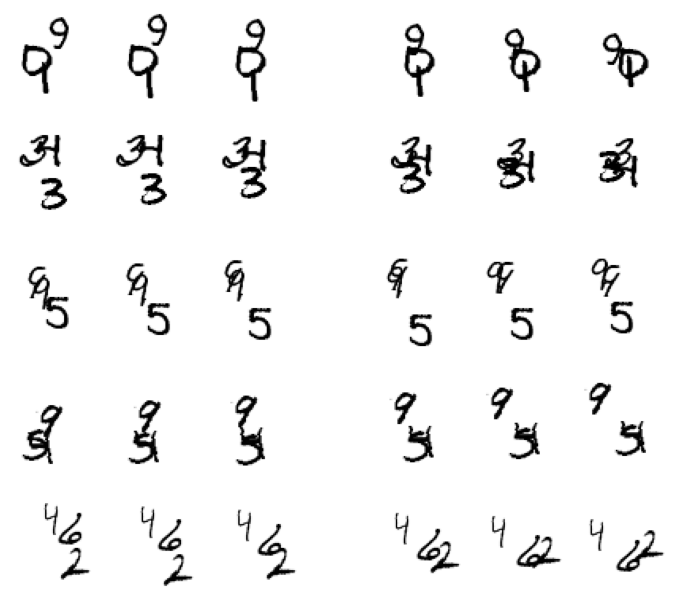

In [ ]:
dls.show_batch()

# Export -

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_data.ipynb.
Converted 01_models.conv_rnn.ipynb.
Converted 02_models.dcn.ipynb.
Converted 02_models.transformer.ipynb.
Converted 02_tcn.ipynb.
Converted index.ipynb.
